In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import center_score
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
lemmas = pd.read_csv("generated_data/Lemmas_VER_cleaned.csv", index_col=0)
lemmas["Part of speech"].unique(), lemmas.columns

(array(['NOM', 'KON', 'ADJ', 'VER', 'ADV', 'PRO:DEM', 'NUM', 'PRP',
        'DET:POS', 'PRO:PER', 'PRO:IND', 'PRO:REL', 'NEG', 'ABR', 'INT',
        'PRO', 'DET:ART', 'NAM', 'PRO:POS', 'PRP:det'], dtype=object),
 Index(['Tokens', 'Len', 'Comment line', 'Part of speech', 'Lemma'], dtype='object'))

In [3]:
pd.options.display.max_rows = 10

In [4]:
lemmas[lemmas["Part of speech"] == 'ADV'] # not useful DET:POS DET:ART PRO:DEM PRP:det PRO:POS INT PRO:REL 'PRO:PER'

,Tokens,Len,Comment line,Part of speech,Lemma
15,encore,6,0,ADV,encore
17,autrement,9,0,ADV,autrement
24,plus,4,0,ADV,plus
28,egalement,9,0,ADV,egalement
31,comme,5,0,ADV,comme
...,...,...,...,...,...
6380940,peu,3,142462,ADV,peu
6380952,relativement,12,142465,ADV,relativement
6380956,peu,3,142465,ADV,peu
6380957,trop,4,142465,ADV,trop


In [5]:
dontkeep = ['DET:POS', 'PRO:IND', 'PRO:DEM', 'PRO:REL', 'ABR', 'INT', 'PRO', 'PRO:PER', 'PRO:POS', 'DET:ART', 'PRP:det', 'PRP', 'KON']
lemmas.shape, lemmas[~lemmas["Part of speech"].isin(dontkeep)].shape

((6327748, 5), (5875334, 5))

In [6]:
lemmas_cleaned = lemmas[~lemmas["Part of speech"].isin(dontkeep)] # le de la un sur
lemmas_cleaned = lemmas_cleaned[~lemmas_cleaned["Lemma"].isin(['le','la', 'un', 'de', 'sur', 'jeu'])] 

In [7]:
# frequence of words in lemmas
freq = lemmas_cleaned["Lemma"].value_counts(normalize=True).reset_index().drop_duplicates()
freq.columns = ['Lemma', 'count']

In [8]:
# freq of words with part of speech
freq = freq.merge(lemmas_cleaned[['Lemma', 'Part of speech']], on='Lemma', how='right').drop_duplicates(subset=['Lemma', 'count'], keep='first')
freq = freq.sort_values(by="count", ascending=False)
corpus_2000 = freq["Lemma"].head(2000)

Text(0.5, 1.0, 'Fréquence des Lemmas dans corpus 2000')

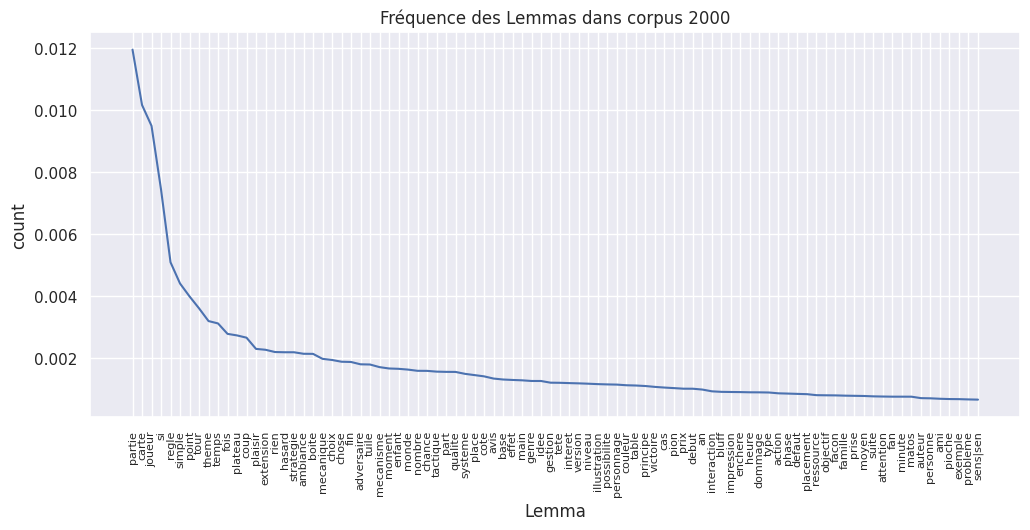

In [9]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(freq[freq["Part of speech"] == 'NOM'].head(90),x='Lemma',y='count')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Fréquence des Lemmas dans corpus 2000")

In [49]:
# regarder par tranches de notations de jeu
# game with >= 20 reviews
avis = pd.read_csv("database_cleaned/avis_clean.csv", index_col = 0)
min_reviews = 20
rev_filter = filter_df(avis, min_reviews)
filtered_centrd_data, _= center_score(rev_filter)

11201 10549
1300 1341
963 1221
925 1200
918 1198
917 1196
916 1192
913 1190


In [22]:
# games that are in the same categ
folder = "database_cleaned"
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
jeux_clean = jeux_clean.dropna()

In [50]:
game_id_cat = jeux_clean[jeux_clean['Type'].str.contains("Jeux de plateau")]["Game id"].unique()

In [51]:
game_id_cat

array([    4,    10,    11, ..., 10538, 10544, 10545])

In [52]:
tmp = rev_filter[rev_filter['Game id'].isin(game_id_cat)]

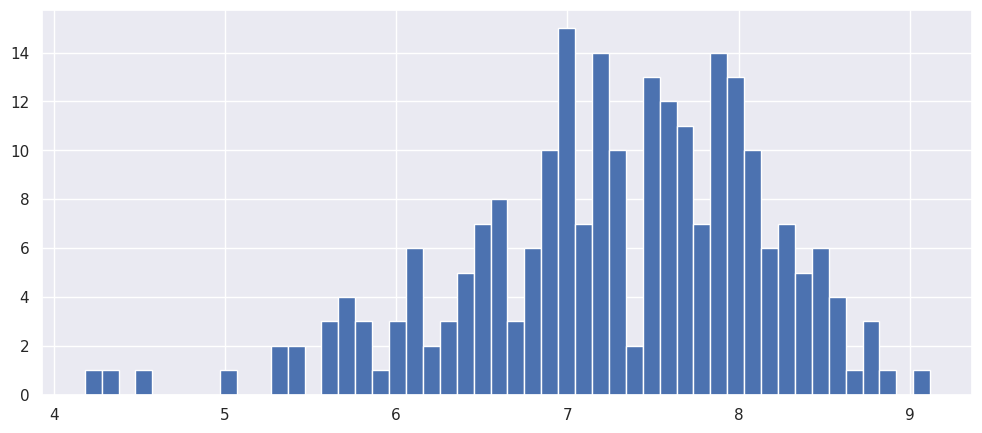

In [53]:
# visualise the mean of the games
game_rank = tmp[["Game id", "Rating"]].groupby("Game id")["Rating"].mean()
_ = plt.hist(game_rank.value_counts().index, bins=50)

In [56]:
# partition
game_rank[(game_rank <= 7)].count(), game_rank[(game_rank > 6) & (game_rank <= 7)].count(), game_rank[(7 < game_rank) & (game_rank < 8)].count(), game_rank[(game_rank >= 8)].count()

(81, 60, 107, 50)

In [57]:
game_rank

Game id
237      7.147541
277      8.432813
281      7.040000
334      8.451515
338      6.909091
           ...   
9987     8.253125
10181    6.962963
10184    7.678571
10192    8.200000
10508    7.188372
Name: Rating, Length: 238, dtype: float64

In [58]:
# filter the positive and negative comments
def pos_neg_freq(data, game_rank, low = 0, high = 10):
    """Return positive negative frequence of games where mean ratings are between ]low;high]
    index given by game_rank"""
    games = data[data["Game id"].isin(game_rank[(low < game_rank) & (game_rank <= high)].index)]
    pos_rev = games[games['Rating'] >= 0]
    neg_rev = games[games['Rating'] < 0]

    return pos_rev, neg_rev

def coms_to_tokens(data, column_name, corpus):
    # original comments to tokens df
    # corpus only has 1 column
    df = data.copy(deep=True)
    df.loc[:, column_name] = df[column_name].apply(lambda x : x.split())
    df = df.explode(column=column_name)
    print(df.shape)
    return df[df[column_name].isin(corpus)]
    
def freq_w(data, column_name):
    # return the frequence for each words in the data
    # words belongs to a corpus, data have comments exploded
    df = data.copy(deep = True)
    freq = df[column_name].value_counts(normalize=True).reset_index()
    freq.columns = ['Lemma', 'count']
    return freq

def diff_frequence(pos_rev, neg_rev, corpus):
    """return the freq positive comments - freq negative comments"""
    pos_rev_lems = coms_to_tokens(pos_rev, "Comment body", set(corpus))
    fpos = freq_w(pos_rev_lems, "Comment body")
    neg_rev_lems = coms_to_tokens(neg_rev, "Comment body", set(corpus))
    fneg = freq_w(neg_rev_lems, "Comment body")

    f_diff = fpos.merge(fneg, on='Lemma')
    f_diff["c_diff"] = f_diff['count_x'] - f_diff['count_y']
    f_diff = f_diff.sort_values(by='c_diff', ascending=False)
    return f_diff

def freq_diff(data, game_rank, corpus, low = 0, high = 10):
    """using lasts functions, returns freq diff of pos and neg comment for games with mean ratings in a certain range"""
    pos_rev, neg_rev = pos_neg_freq(data, game_rank, low, high)
    return diff_frequence(pos_rev, neg_rev, corpus)


In [59]:
f_diff = freq_diff(filtered_centrd_data, game_rank, corpus_2000.values, low = 0, high = 6)
f_diff

(12459, 8)
(49047, 8)


,Lemma,count_x,count_y,c_diff
5,bon,0.018312,0.010205,0.008107
15,extension,0.010272,0.002388,0.007884
2,bien,0.036177,0.029638,0.006538
19,tactique,0.009379,0.003474,0.005905
20,aussi,0.008933,0.003800,0.005133
...,...,...,...,...
68,vite,0.002680,0.006948,-0.004268
7,fait,0.015632,0.022147,-0.006515
3,ne,0.035284,0.042775,-0.007491
0,pas,0.069227,0.077516,-0.008289


Text(0.5, 1.0, 'Frequence Lemmas pos corpus 2000 games mean <= 6')

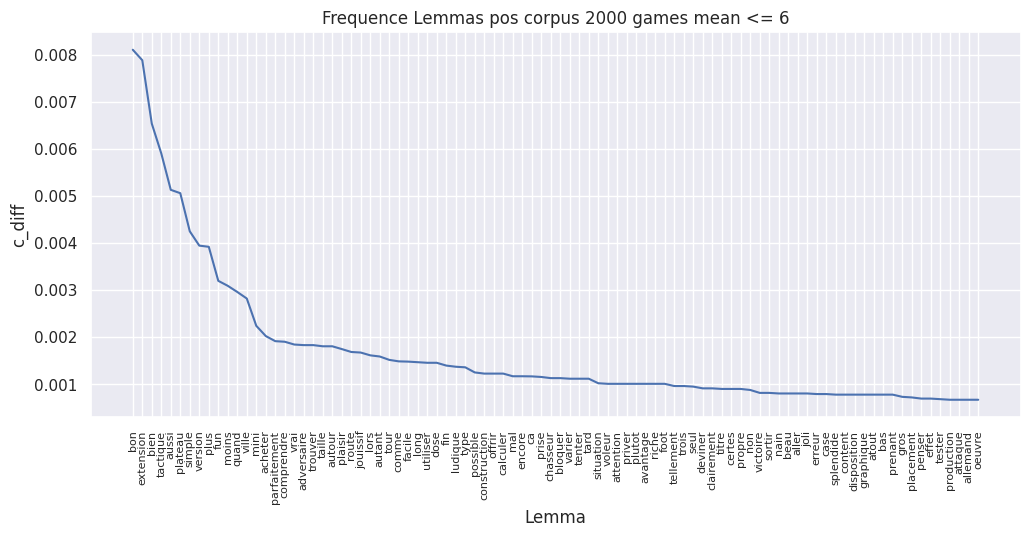

In [60]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(data=f_diff.head(90),x='Lemma',y='c_diff')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Frequence Lemmas pos corpus 2000 games mean <= 6")

Text(0.5, 1.0, 'Frequence Lemmas pos corpus 2000 games mean <= 6')

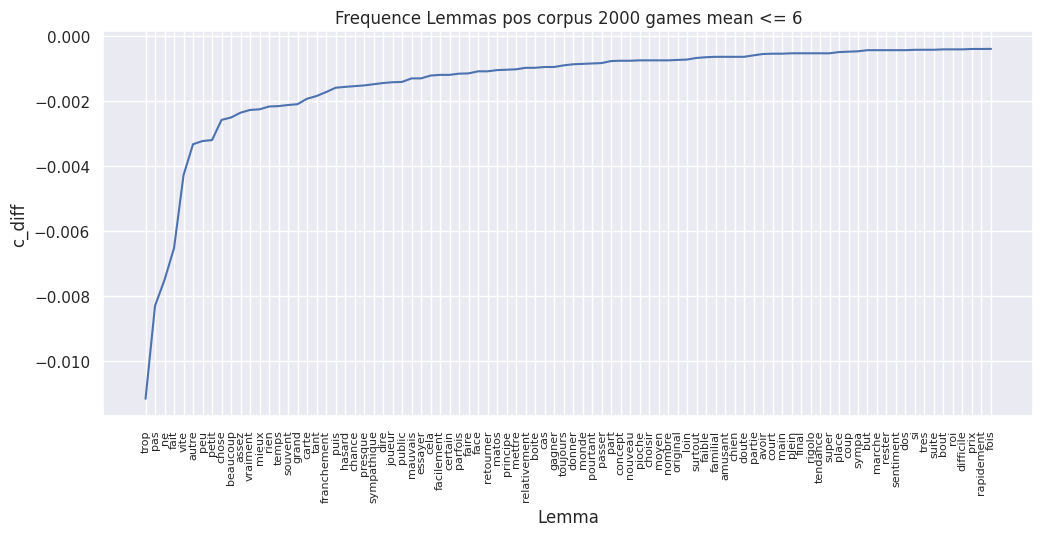

In [61]:
sns.set_theme(rc={'figure.figsize' : (12, 5)})
ax = sns.lineplot(data=f_diff.tail(90)[::-1],x='Lemma',y='c_diff')
ax.tick_params(axis='x', rotation=90, labelsize=8)
ax.set_title("Frequence Lemmas pos corpus 2000 games mean <= 6")

In [62]:
import nltk
from collections import Counter
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import BigramAssocMeasures
bigram_measures = BigramAssocMeasures()

def coms_to_bigrm(data, column_name, corpus):
    # original comments to tokens
    # corpus only has 1 column
    df = data.copy(deep=True)
    df.loc[:, column_name] = df[column_name].str.lower().apply(lambda x : x.split())
    df.loc[:, column_name] = df[column_name].apply(lambda x: [lem for lem in x if lem in set(corpus)])
    return sec(df, column_name)

def sec(data, column_name):
    """bigramm on data column_name"""
    df = data.copy(deep=True)
    df.loc[:, column_name] = df[column_name].apply(lambda x: BigramCollocationFinder.from_words(nltk.word_tokenize(" ".join(x)) if len(np.unique(x)) > 1 else "").nbest(BigramAssocMeasures.pmi, 10))

    df = df.explode(column=column_name)
    return df

def data_big(data, corpus, game_rank, low = 0, high = 10):
    """from df to bigram"""
    pos, neg = pos_neg_freq(data, game_rank, low, high)
    pos_big, neg_big = coms_to_bigrm(pos, 'Comment body', corpus), coms_to_bigrm(neg, 'Comment body', corpus) 
    return pos_big, neg_big


def calculate_bigram_frequencies(bigrams):
    """calc freq of bigram"""
    bigram_frequencies = Counter(bigrams)
    total = sum(bigram_frequencies.values())
    bigram_frequencies_n = {key: count / total for key, count in bigram_frequencies.items()}
    
    bigram_freq_df = pd.DataFrame(bigram_frequencies_n.items(), columns=['Bigram', 'Frequency'])
    bigram_freq_df = bigram_freq_df.sort_values(by='Frequency', ascending=False)
    
    bigram_freq_df['Bigram'] = bigram_freq_df['Bigram'].apply(lambda x: ' '.join(x) if isinstance(x, tuple) else str(x))
    
    return bigram_freq_df

def big_freq(data, corpus, game_rank, low=0, high=10):
    pos_big, neg_big = data_big(data, corpus, game_rank, low, high)
    
    bigram_freq_df_pos = calculate_bigram_frequencies(pos_big['Comment body'])
    bigram_freq_df_neg = calculate_bigram_frequencies(neg_big['Comment body'])

    diff = bigram_freq_df_pos.merge(bigram_freq_df_neg, on="Bigram")
    diff["diff_freq"] = diff["Frequency_x"] - diff["Frequency_y"]
    diff = diff.sort_values(by="diff_freq", ascending=False)
    return bigram_freq_df_pos, bigram_freq_df_neg, diff

In [64]:
bigf_pos, bigf_neg, diff = big_freq(filtered_centrd_data, corpus_2000.values, game_rank, low=0, high=7)

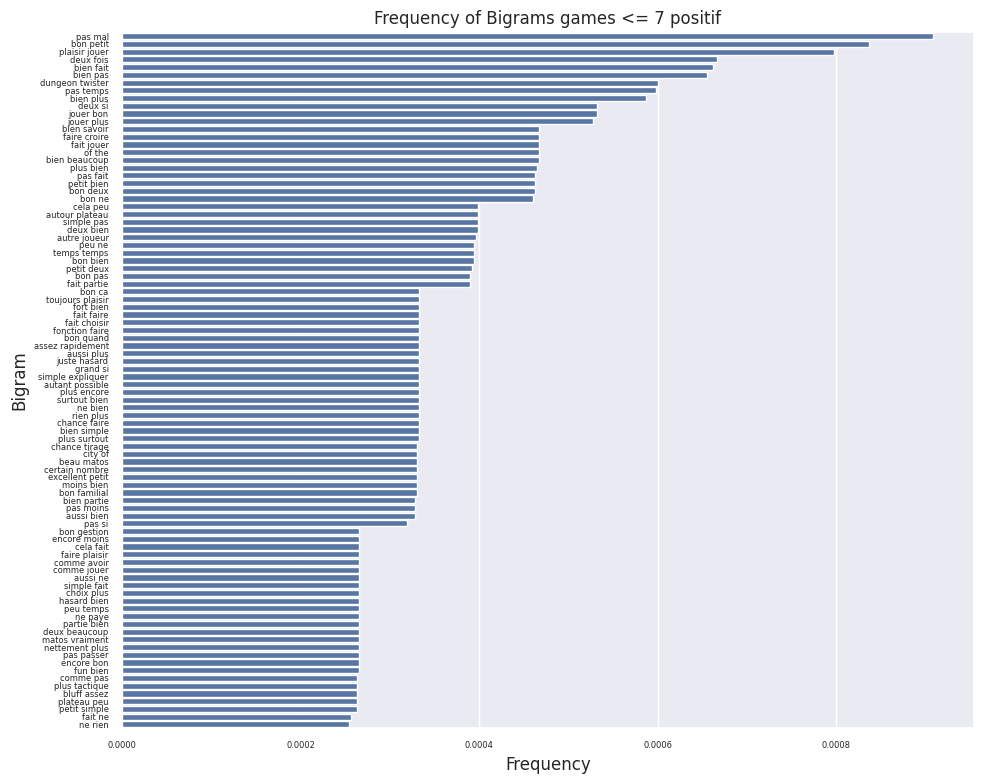

In [67]:
plt.figure(figsize=(10, 8))
sns.barplot(x='diff_freq', y='Bigram', data=diff.head(90), orient='h')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Frequency of Bigrams games <= 7 positif')
plt.tick_params(axis='both', labelsize=6) 
plt.tight_layout()
plt.show()

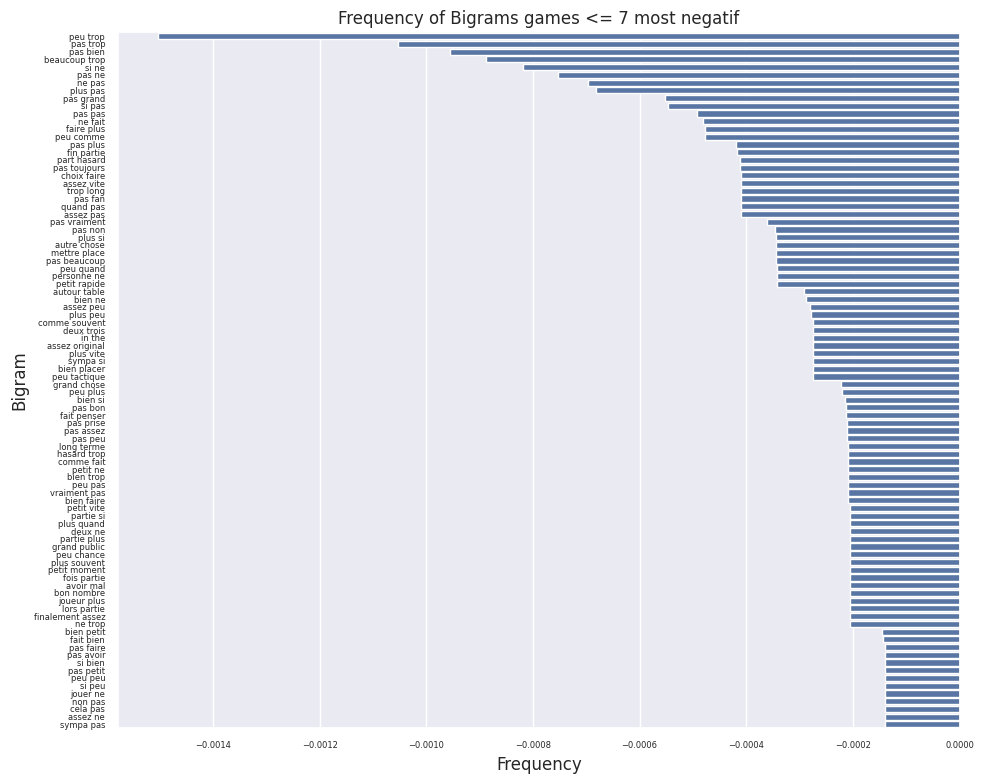

In [68]:
plt.figure(figsize=(10, 8))
sns.barplot(x='diff_freq', y='Bigram', data=diff.tail(90)[::-1], orient='h')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Frequency of Bigrams games <= 7 most negatif')
plt.tick_params(axis='both', labelsize=6) 
plt.tight_layout()
plt.show()

In [ ]:
bigf_pos, bigf_neg, diff = big_freq(filtered_centrd_data, corpus_2000.values, game_rank, low=7, high=8)

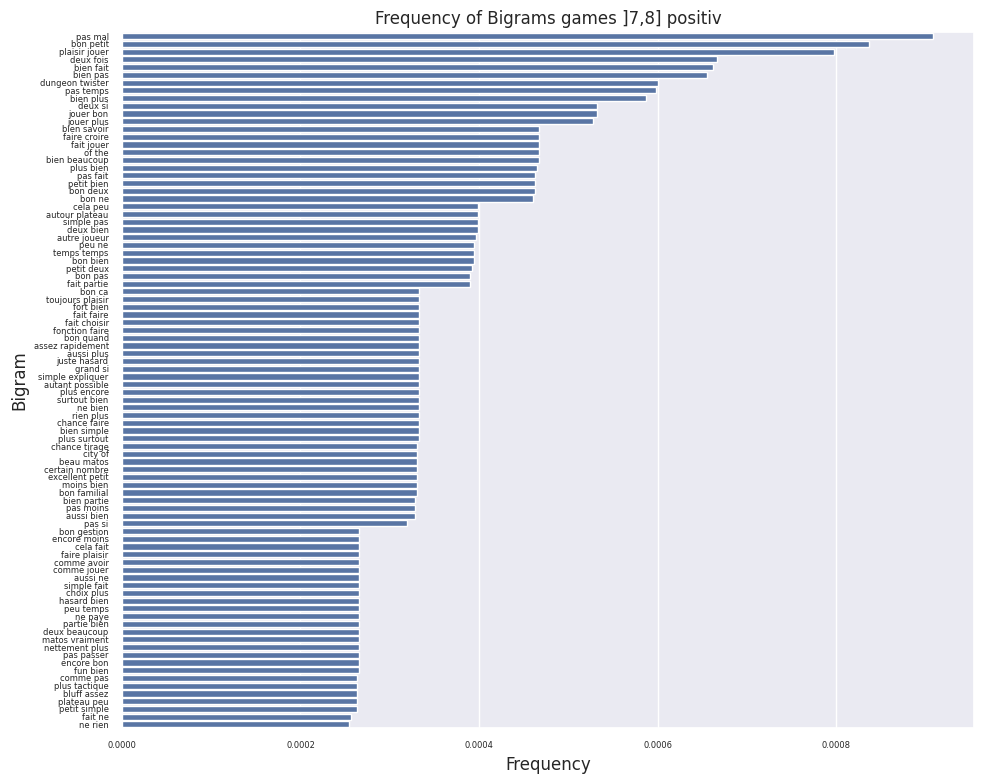

In [69]:
plt.figure(figsize=(10, 8))
sns.barplot(x='diff_freq', y='Bigram', data=diff.head(90), orient='h')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Frequency of Bigrams games ]7,8] positiv')
plt.tick_params(axis='both', labelsize=6) 
plt.tight_layout()
plt.show()

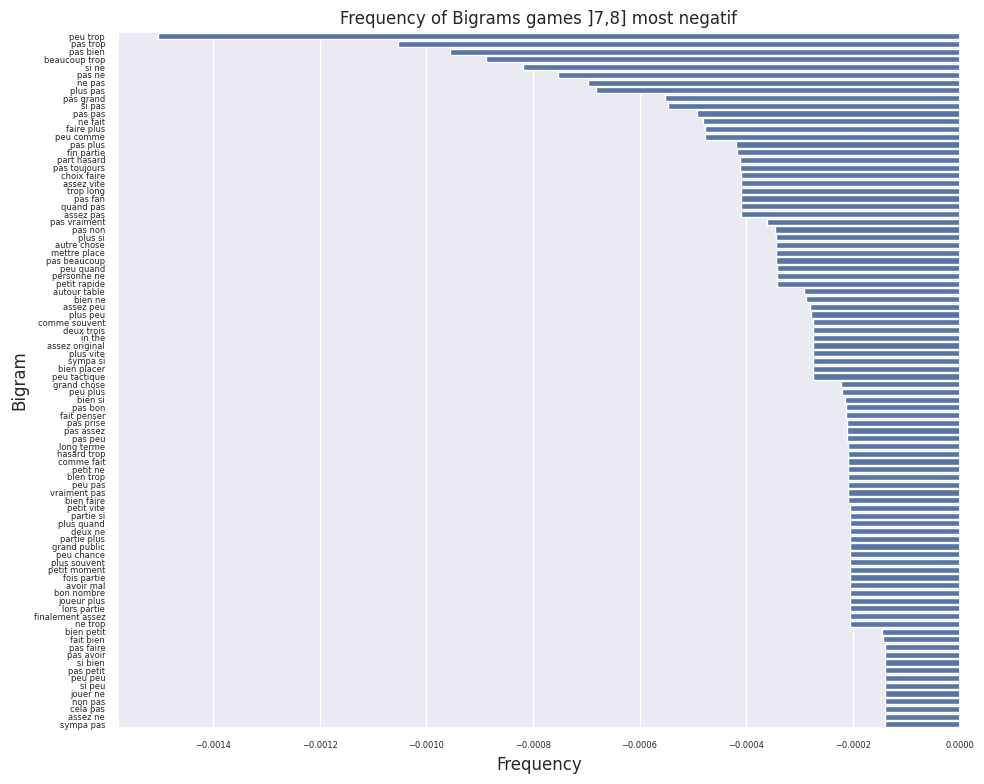

In [70]:
plt.figure(figsize=(10, 8))
sns.barplot(x='diff_freq', y='Bigram', data=diff.tail(90)[::-1], orient='h')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Frequency of Bigrams games ]7,8] most negatif')
plt.tick_params(axis='both', labelsize=6) 
plt.tight_layout()
plt.show()

In [71]:
bigf_pos, bigf_neg, diff = big_freq(filtered_centrd_data, corpus_2000.values, game_rank, low=8)

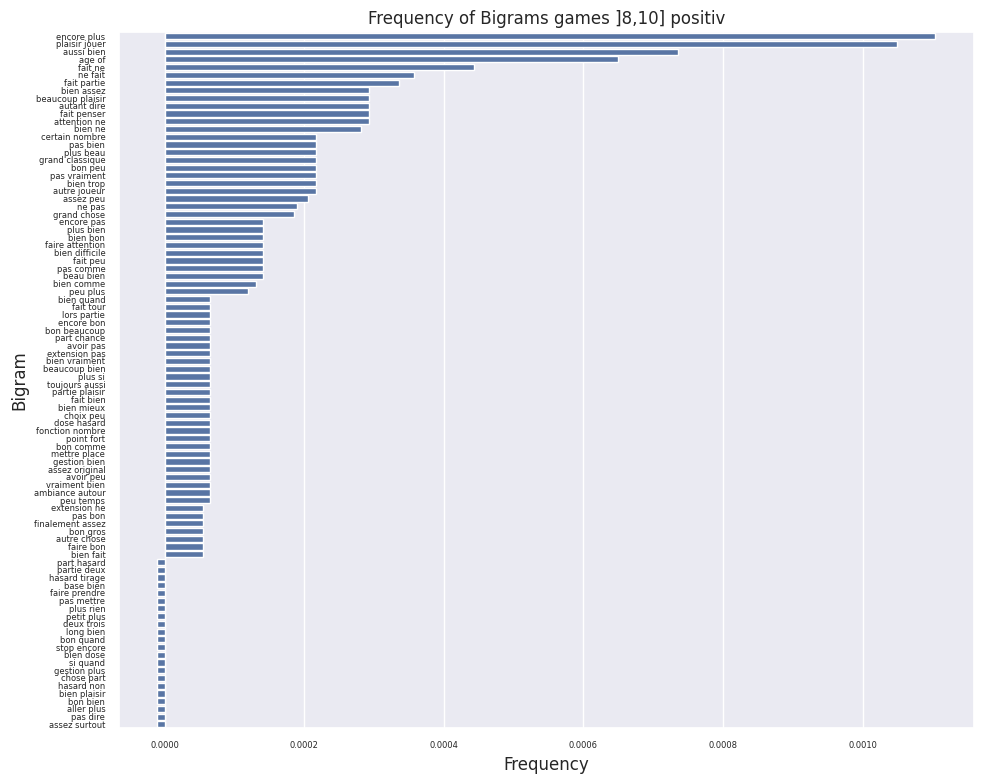

In [72]:
plt.figure(figsize=(10, 8))
sns.barplot(x='diff_freq', y='Bigram', data=diff.head(90), orient='h')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Frequency of Bigrams games ]8,10] positiv')
plt.tick_params(axis='both', labelsize=6) 
plt.tight_layout()
plt.show()

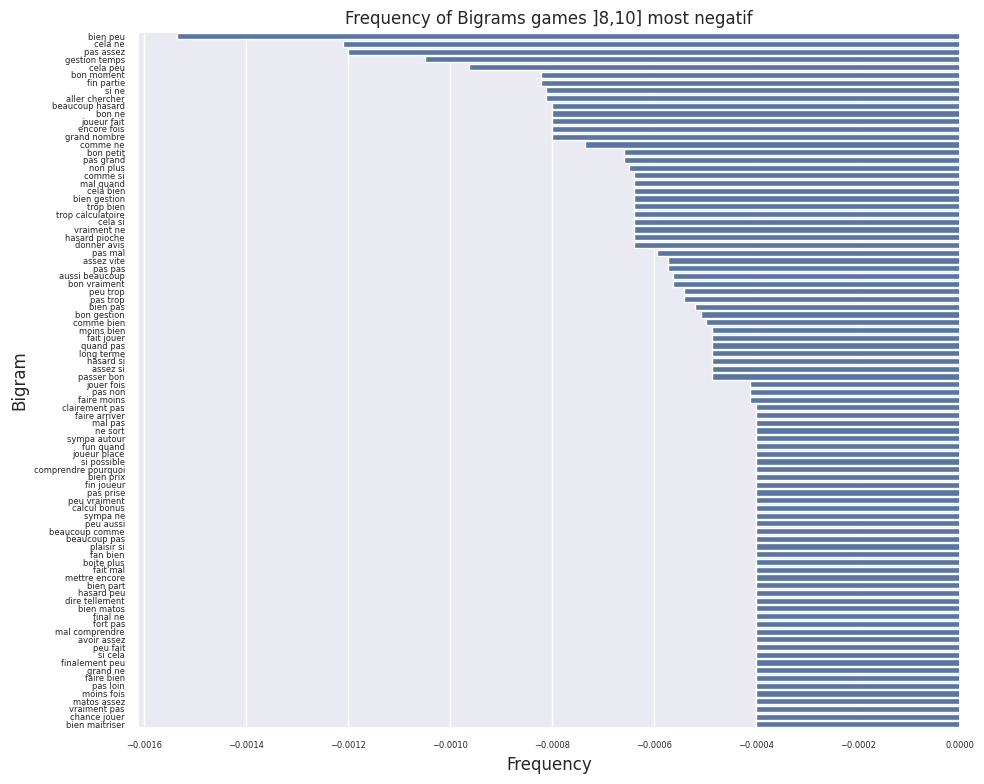

In [73]:
plt.figure(figsize=(10, 8))
sns.barplot(x='diff_freq', y='Bigram', data=diff.tail(90)[::-1], orient='h')
plt.xlabel('Frequency')
plt.ylabel('Bigram')
plt.title('Frequency of Bigrams games ]8,10] most negatif')
plt.tick_params(axis='both', labelsize=6) 
plt.tight_layout()
plt.show()